This is Simon's independent code that was developed at the same time as Will's. It has been used to check Will's numbers. It also performs the mixture modelling and produces plots of the posterior on the mixing fraction f_i 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import emcee
import corner
import os
# from emcee import PTSampler
# from scipy.integrate import trapz
%matplotlib inline

big_enough_font=20

In [2]:
this_plot_folder = "detections_spin_measurement/"

if(np.logical_not(os.path.exists(this_plot_folder))):
    os.mkdir(this_plot_folder)

In [3]:
npts = int(1E6)
aligned_model_costheta1 = np.ones(npts)
aligned_model_costheta2 = np.ones(npts)

gaussian_aligned_model_costheta1_trial = scipy.stats.norm.rvs(loc=1.0, scale=0.1, size=npts*10)
gaussian_aligned_model_costheta2_trial = scipy.stats.norm.rvs(loc=1.0, scale=0.1, size=npts*10)

gaussian_aligned_costheta1_ok = np.logical_and(gaussian_aligned_model_costheta1_trial >= -1.0, gaussian_aligned_model_costheta1_trial <= 1.0)
gaussian_aligned_costheta2_ok = np.logical_and(gaussian_aligned_model_costheta2_trial >= -1.0, gaussian_aligned_model_costheta2_trial <= 1.0)
gaussian_aligned_both_ok = np.logical_and(gaussian_aligned_costheta1_ok, gaussian_aligned_costheta2_ok)

gaussian_aligned_model_costheta1 = gaussian_aligned_model_costheta1_trial[gaussian_aligned_both_ok][0:npts]
gaussian_aligned_model_costheta2 = gaussian_aligned_model_costheta2_trial[gaussian_aligned_both_ok][0:npts]

isotropic_model_costheta1 = np.random.uniform(-1,1,npts)
isotropic_model_costheta2 = np.random.uniform(-1,1,npts)

In [4]:
print(len(gaussian_aligned_model_costheta1))

1000000


In [5]:
# plt.figure()
# plt.clf()
# plt.scatter(gaussian_aligned_model_costheta1, gaussian_aligned_model_costheta2, marker='x')
# plt.xlim([-1.0, 1.0])
# plt.ylim([-1.0, 1.0])
# plt.xlabel(r"")
# plt.ylabel(r"")
# plt.tight_layout()

In [6]:
# # plt.scatter(aligned_model_costheta1, aligned_model_costheta2)
# plt.figure()
# plt.clf()
# plt.scatter(isotropic_model_costheta1, isotropic_model_costheta2, marker='x')
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.xlabel(r"")
# plt.ylabel(r"")
# plt.tight_layout()

In [7]:
def chi_eff(q, chi1, chi2, costheta1, costheta2):
    return (chi1*costheta1 + q*chi2*costheta2)/(1.0+q)

In [8]:
def p_inverse_thermal(x):
    return 2.0*(1.0 - x)

def p_thermal(x):
    return 2.0*(x)

def p_power_law(x):
    return 0

def p_extremely_low(x):
    return (1.0-x)**4.0

def p_extremely_high(x):
    return x**4.0

In [9]:
x = np.linspace(0.0, 1.0, 100)
prob_inverse_thermal = p_inverse_thermal(x)
prob_thermal = p_thermal(x)

In [10]:
# print(np.sum(p_extremely_low(x)) * 0.01)
# print(np.sum(p_inverse_thermal(x)) * 0.01) 
# print(np.mean(p_inverse_thermal(x)))
# print(np.mean(p_extremely_low(x)))

In [11]:
ZERO_SPIN_MAGNITUDE = 0
UNIFORM_SPIN_MAGNITUDE = 1
THERMAL_SPIN_MAGNITUDE = 2
INVERSE_THERMAL_SPIN_MAGNITUDE = 3
EXTREMELY_LOW_SPIN_MAGNITUDE = 4 
EXTREMELY_HIGH_SPIN_MAGNITUDE = 5
PROXY_ALIGNED = 6
PROXY_ISOTROPIC = 7

In [12]:
#--- Model where all black holes have a fixed spin
fixed_spin_magnitude = 1.0
chi1_fixed = np.ones(npts) * fixed_spin_magnitude
chi2_fixed = np.ones(npts) * fixed_spin_magnitude

#-- Model where black holes have spins uniform in 0,1
chi1_uniform = np.random.uniform(0.0, 1.0, npts)
chi2_uniform = np.random.uniform(0.0, 1.0, npts)

#-- Model where all black holes are born non spinnning
chi1_zero = np.zeros(npts)
chi2_zero = np.zeros(npts)

#-- I think the dominant uncertainty is in not knowing what the distribution 
# of spin magnitudes are - make an alternative simple model of spin magnitude distribution
# and test effect on inference
chi1_inverse_thermal = np.random.uniform(0.0, 1.0, 3*npts)
prob_chi1_inverse_thermal = p_inverse_thermal(chi1_inverse_thermal)
chi1_rands = np.random.uniform(0.0, max(prob_chi1_inverse_thermal), 3*npts)
chi1_keep = chi1_rands < prob_chi1_inverse_thermal
chi1_inverse_thermal = chi1_inverse_thermal[chi1_keep]
if(len(chi1_inverse_thermal) > npts):
    chi1_inverse_thermal = chi1_inverse_thermal[0:npts]
# print(len(chi1_inverse_thermal))

chi1_thermal = np.random.uniform(0.0, 1.0, 3*npts)
prob_chi1_thermal = p_thermal(chi1_thermal)
chi1_rands = np.random.uniform(0.0, max(prob_chi1_thermal), 3*npts)
chi1_keep = chi1_rands < prob_chi1_thermal
chi1_thermal = chi1_thermal[chi1_keep]
if(len(chi1_thermal) > npts):
    chi1_thermal = chi1_thermal[0:npts]

chi2_inverse_thermal = np.random.uniform(0.0, 1.0, 3*npts)
prob_chi2_inverse_thermal = p_inverse_thermal(chi2_inverse_thermal)
chi2_rands = np.random.uniform(0.0, max(prob_chi2_inverse_thermal), 3*npts)
chi2_keep = chi2_rands < prob_chi2_inverse_thermal
chi2_inverse_thermal = chi2_inverse_thermal[chi2_keep]
if(len(chi2_inverse_thermal) > npts):
    chi2_inverse_thermal = chi2_inverse_thermal[0:npts]
# print(len(chi2_inverse_thermal))

chi2_thermal = np.random.uniform(0.0, 1.0, 3*npts)
prob_chi2_thermal = p_thermal(chi2_thermal)
chi2_rands = np.random.uniform(0.0, max(prob_chi2_thermal), 3*npts)
chi2_keep = chi2_rands < prob_chi2_thermal
chi2_thermal = chi2_thermal[chi2_keep]
if(len(chi2_thermal) > npts):
    chi2_thermal = chi2_thermal[0:npts]

mass_ratio = np.ones(npts)

In [13]:
print("Flat: prob a < 0.2 = ", np.sum(chi1_uniform < 0.2)/len(chi1_uniform))
print("Low: prob a < 0.2 = ", np.sum(chi1_inverse_thermal < 0.2)/len(chi1_inverse_thermal))
print("High: prob a < 0.2 = ", np.sum(chi1_thermal < 0.2)/len(chi1_thermal))

Flat: prob a < 0.2 =  0.200171
Low: prob a < 0.2 =  0.358881
High: prob a < 0.2 =  0.040462


In [14]:
nmultiplier=10
chi1_extremely_high = np.random.uniform(0.0, 1.0, nmultiplier*npts)
prob_chi1_extremely_high = p_extremely_high(chi1_extremely_high)
chi1_rands = np.random.uniform(0.0, max(prob_chi1_extremely_high), nmultiplier*npts)
chi1_keep = chi1_rands < prob_chi1_extremely_high
chi1_extremely_high = chi1_extremely_high[chi1_keep]
if(len(chi1_extremely_high) > npts):
    chi1_extremely_high = chi1_extremely_high[0:npts]
else:
    print(len(chi1_extremely_high))
    
nmultiplier=10
chi2_extremely_high = np.random.uniform(0.0, 1.0, nmultiplier*npts)
prob_chi2_extremely_high = p_extremely_high(chi2_extremely_high)
chi2_rands = np.random.uniform(0.0, max(prob_chi2_extremely_high), nmultiplier*npts)
chi2_keep = chi2_rands < prob_chi2_extremely_high
chi2_extremely_high = chi2_extremely_high[chi2_keep]
if(len(chi2_extremely_high) > npts):
    chi2_extremely_high = chi2_extremely_high[0:npts]
else:
    print(len(chi2_extremely_high))

In [15]:
nmultiplier=10
chi1_extremely_low = np.random.uniform(0.0, 1.0, nmultiplier*npts)
prob_chi1_extremely_low = p_extremely_low(chi1_extremely_low)
chi1_rands = np.random.uniform(0.0, max(prob_chi1_extremely_low), nmultiplier*npts)
chi1_keep = chi1_rands < prob_chi1_extremely_low
chi1_extremely_low = chi1_extremely_low[chi1_keep]
if(len(chi1_extremely_low) > npts):
    chi1_extremely_low = chi1_extremely_low[0:npts]
else:
    print(len(chi1_extremely_low))

nmultiplier=10
chi2_extremely_low = np.random.uniform(0.0, 1.0, nmultiplier*npts)
prob_chi2_extremely_low = p_extremely_low(chi2_extremely_low)
chi2_rands = np.random.uniform(0.0, max(prob_chi2_extremely_low), nmultiplier*npts)
chi2_keep = chi2_rands < prob_chi2_extremely_low
chi2_extremely_low = chi2_extremely_low[chi2_keep]
if(len(chi2_extremely_low) > npts):
    chi2_extremely_low = chi2_extremely_low[0:npts]
else:
    print(len(chi2_extremely_low))

In [29]:
print("Extremely Low: prob a < 0.2 = ", np.sum(chi1_extremely_low < 0.2)/len(chi1_extremely_low))
print("Extremely High: prob a < 0.2 = ", np.sum(chi1_extremely_high < 0.2)/len(chi1_extremely_high))

Extremely Low: prob a < 0.2 =  0.67214
Extremely High: prob a < 0.2 =  0.000327


/Users/simons/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


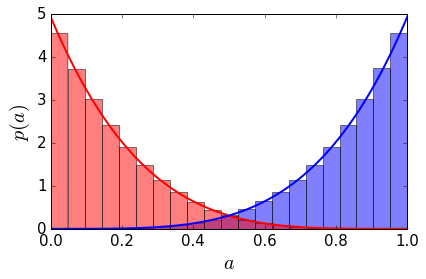

In [30]:
figname="spin_magnitude_distributions_extreme"
plt.figure()
plt.clf()
# plt.plot(x, p_inverse_thermal(x))
plt.plot(x, p_extremely_low(x)/(np.sum(p_extremely_low(x)) * 0.01), color='r', lw=2, label=r"")
# plt.plot(x, p_thermal(x))
plt.plot(x, p_extremely_high(x)/(np.sum(p_extremely_high(x)) * 0.01), color='b', lw=2, label=r"")
plt.hist(chi1_extremely_high, bins=20, normed=True, color='blue', alpha=0.5, label=r"")
plt.hist(chi1_extremely_low, bins=20, normed=True, color='red', alpha=0.5, label=r"")
# plt.plot(x, prob_inverse_thermal, lw=2, color='blue', ls='-', label=r"$p(a)=2(1-a)$")
# plt.plot(x, prob_thermal, lw=2, color='red', ls='--', label=r"$p(a)=2a$")
# plt.hist(chi1_inverse_thermal, bins=20, normed=True, color='blue', alpha=0.5)
# plt.hist(chi1_thermal, bins=20, normed=True, color='red', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper center', framealpha=1.0, fancybox=True)
plt.xlabel(r"$a$", fontsize=20)
plt.ylabel(r"$p(a)$", fontsize=20)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

In [31]:
print("Extremely Low:", np.mean(chi1_extremely_low))
print("Extremely High:", np.mean(chi2_extremely_high))

Extremely Low: 0.166686939808
Extremely High: 0.833641029335


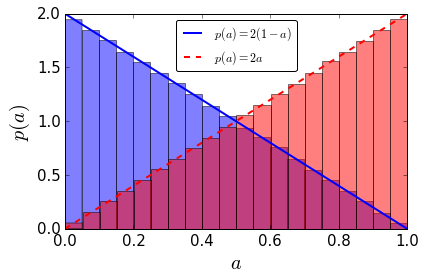

In [37]:
figname="spin_magnitude_distributions_thermal"
plt.figure()
plt.clf()
plt.plot(x, prob_inverse_thermal, lw=2, color='blue', ls='-', label=r"$p(a)=2(1-a)$")
plt.plot(x, prob_thermal, lw=2, color='red', ls='--', label=r"$p(a)=2a$")
# plt.plot(x, np.ones_like(x), lw=2, color='green', ls=':', label=r"$p(a)=1$")
plt.hist(chi1_inverse_thermal, bins=20, normed=True, color='blue', alpha=0.5)
plt.hist(chi1_thermal, bins=20, normed=True, color='red', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper center', framealpha=1.0, fancybox=True)
plt.xlabel(r"$a$", fontsize=20)
plt.ylabel(r"$p(a)$", fontsize=20)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

In [33]:
chi_eff_aligned_fixed_spin = chi_eff(mass_ratio, chi1_fixed, chi2_fixed, aligned_model_costheta1, aligned_model_costheta2)
chi_eff_aligned_uniform_spin = chi_eff(mass_ratio, chi1_uniform, chi2_uniform, aligned_model_costheta1, aligned_model_costheta2)
chi_eff_aligned_inverse_thermal_spin = chi_eff(mass_ratio, chi1_inverse_thermal, chi2_inverse_thermal, aligned_model_costheta1, aligned_model_costheta2)
chi_eff_aligned_thermal_spin = chi_eff(mass_ratio, chi1_thermal, chi2_thermal, aligned_model_costheta1, aligned_model_costheta2)

chi_eff_gaussian_aligned_fixed_spin = chi_eff(mass_ratio, chi1_fixed, chi2_fixed, gaussian_aligned_model_costheta1, gaussian_aligned_model_costheta2)
chi_eff_gaussian_aligned_uniform_spin = chi_eff(mass_ratio, chi1_fixed, chi2_fixed, gaussian_aligned_model_costheta1, gaussian_aligned_model_costheta2)
chi_eff_gaussian_aligned_inverse_thermal_spin = chi_eff(mass_ratio, chi1_inverse_thermal, chi2_inverse_thermal, gaussian_aligned_model_costheta1, gaussian_aligned_model_costheta2)
chi_eff_gaussian_aligned_thermal_spin = chi_eff(mass_ratio, chi1_thermal, chi2_thermal, gaussian_aligned_model_costheta1, gaussian_aligned_model_costheta2)

chi_eff_isotropic_fixed_spin = chi_eff(mass_ratio, chi1_fixed, chi2_fixed, isotropic_model_costheta1, isotropic_model_costheta2)
chi_eff_isotropic_uniform_spin = chi_eff(mass_ratio, chi1_uniform, chi2_uniform, isotropic_model_costheta1, isotropic_model_costheta2)
chi_eff_isotropic_inverse_thermal_spin = chi_eff(mass_ratio, chi1_inverse_thermal, chi2_inverse_thermal, isotropic_model_costheta1, isotropic_model_costheta2)
chi_eff_isotropic_thermal_spin = chi_eff(mass_ratio, chi1_thermal, chi2_thermal, isotropic_model_costheta1, isotropic_model_costheta2)

chi_eff_zero = chi_eff(mass_ratio, chi1_zero, chi2_zero, aligned_model_costheta1, aligned_model_costheta2)

In [34]:
chi_eff_aligned_extremely_low = chi_eff(mass_ratio, chi1_extremely_low, chi2_extremely_low, aligned_model_costheta1, aligned_model_costheta2)
chi_eff_isotropic_extremely_low = chi_eff(mass_ratio, chi1_extremely_low, chi2_extremely_low, isotropic_model_costheta1, isotropic_model_costheta2)

chi_eff_aligned_extremely_high = chi_eff(mass_ratio, chi1_extremely_high, chi2_extremely_high, aligned_model_costheta1, aligned_model_costheta2)
chi_eff_isotropic_extremely_high = chi_eff(mass_ratio, chi1_extremely_high, chi2_extremely_high, isotropic_model_costheta1, isotropic_model_costheta2)

In [35]:
chi_eff_flat_above_zero = np.random.uniform(0.0, 1.0, npts)
chi_eff_flat_minus_one_one = np.random.uniform(-1.0, 1.0, npts)

In [38]:
nbins_chi_eff = 100 #40
binwidth_chi_eff = (1.0 - -1.0)/nbins_chi_eff
bins_chi_eff = np.linspace(-1.0, 1.0, nbins_chi_eff)

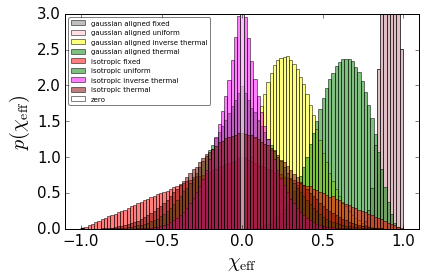

In [39]:
figname="smeared_chi_eff_spin_magnitude_with_inverse_thermal"
plt.figure()
plt.clf()

# plt.hist(chi_eff_aligned_fixed_spin, bins=bins_chi_eff, color='black', alpha=0.5, label=r"aligned fixed", normed=True) #histtype='step'
# plt.hist(chi_eff_aligned_uniform_spin, bins=bins_chi_eff, color='blue', alpha=0.5, label=r"aligned uniform", normed=True) #histtype='step'
# plt.hist(chi_eff_aligned_inverse_thermal_spin, bins=bins_chi_eff, color='cyan', alpha=0.5, label=r"aligned inverse thermal", normed=True) #histtype='step'
# plt.hist(chi_eff_aligned_thermal_spin, bins=bins_chi_eff, color=[0,0,0.5], alpha=0.5, label=r"aligned thermal", normed=True)

plt.hist(chi_eff_gaussian_aligned_fixed_spin, bins=bins_chi_eff, color='gray', alpha=0.5, label=r"gaussian aligned fixed", normed=True) #histtype='step'
plt.hist(chi_eff_gaussian_aligned_uniform_spin, bins=bins_chi_eff, color='pink', alpha=0.5, label=r"gaussian aligned uniform", normed=True) #histtype='step'
plt.hist(chi_eff_gaussian_aligned_inverse_thermal_spin, bins=bins_chi_eff, color='yellow', alpha=0.5, label=r"gaussian aligned inverse thermal", normed=True) #histtype='step'
plt.hist(chi_eff_gaussian_aligned_thermal_spin, bins=bins_chi_eff, color=[0,0.5,0], alpha=0.5, label=r"gaussian aligned thermal", normed=True)

plt.hist(chi_eff_isotropic_fixed_spin, bins=bins_chi_eff, color='red', alpha=0.5, label=r"isotropic fixed", normed=True)
plt.hist(chi_eff_isotropic_uniform_spin, bins=bins_chi_eff, color='green', alpha=0.5, label=r"isotropic uniform", normed=True) #histtype='step',
plt.hist(chi_eff_isotropic_inverse_thermal_spin, bins=bins_chi_eff, color='magenta', alpha=0.5, label=r"isotropic inverse thermal", normed=True) #histtype='step',
plt.hist(chi_eff_isotropic_thermal_spin, bins=bins_chi_eff, color=[0.5,0,0], alpha=0.5, label=r"isotropic thermal", normed=True)

plt.hist(chi_eff_zero, bins=bins_chi_eff, color='white', alpha=0.5, label=r"zero", normed=True)

plt.xlim([-1.1,1.1])
plt.ylim([0.0, 3.0])
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=7)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

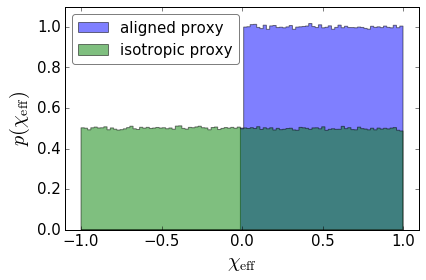

In [40]:
figname="proxy_models"
plt.figure()
plt.clf()

plt.hist(chi_eff_flat_above_zero, bins=bins_chi_eff, color='blue', alpha=0.5, histtype='stepfilled', label=r"aligned proxy", normed=True) #histtype='step'
plt.hist(chi_eff_flat_minus_one_one, bins=bins_chi_eff, color='green', alpha=0.5, histtype='stepfilled', label=r"isotropic proxy", normed=True) #histtype='step',

plt.xlim([-1.1,1.1])
plt.ylim([0.0, 1.1])
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=15)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

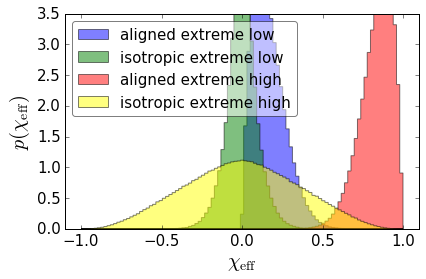

In [41]:
figname="extreme_only_models"
plt.figure()
plt.clf()

plt.hist(chi_eff_aligned_extremely_low, bins=bins_chi_eff, color='blue', alpha=0.5, histtype='stepfilled', label=r"aligned extreme low", normed=True) #histtype='step'
plt.hist(chi_eff_isotropic_extremely_low, bins=bins_chi_eff, color='green', alpha=0.5, histtype='stepfilled', label=r"isotropic extreme low", normed=True) #histtype='step',

plt.hist(chi_eff_aligned_extremely_high, bins=bins_chi_eff, color='red', alpha=0.5, histtype='stepfilled', label=r"aligned extreme high", normed=True) #histtype='step'
plt.hist(chi_eff_isotropic_extremely_high, bins=bins_chi_eff, color='yellow', alpha=0.5, histtype='stepfilled', label=r"isotropic extreme high", normed=True) #histtype='step',

plt.xlim([-1.1,1.1])
plt.ylim([0.0, 3.5])
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=15)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

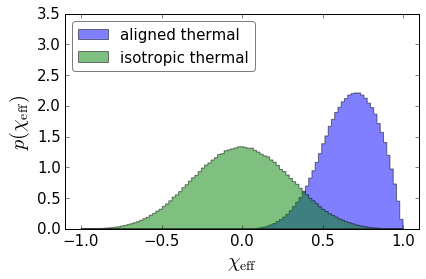

In [42]:
figname="thermal_only_models"
plt.figure()
plt.clf()
plt.hist(chi_eff_aligned_thermal_spin, bins=bins_chi_eff, color='blue', alpha=0.5, histtype='stepfilled', label=r"aligned thermal", normed=True) #histtype='step'
plt.hist(chi_eff_isotropic_thermal_spin, bins=bins_chi_eff, color='green', alpha=0.5, histtype='stepfilled', label=r"isotropic thermal", normed=True) #histtype='step',
plt.xlim([-1.1,1.1])
plt.ylim([0.0, 3.5])
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=15)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

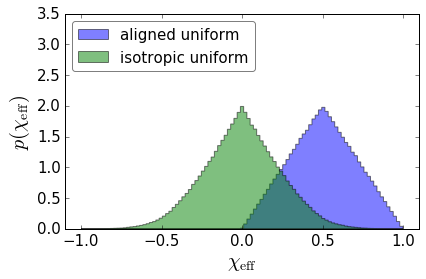

In [43]:
figname="uniform_only_models"
plt.figure()
plt.clf()
plt.hist(chi_eff_aligned_uniform_spin, bins=bins_chi_eff, color='blue', histtype='stepfilled', alpha=0.5, label=r"aligned uniform", normed=True) #histtype='step'
plt.hist(chi_eff_isotropic_uniform_spin, bins=bins_chi_eff, color='green', histtype='stepfilled', alpha=0.5, label=r"isotropic uniform", normed=True) #histtype='step',
plt.xlim([-1.1,1.1])
plt.ylim([0.0, 3.5])
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=15)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

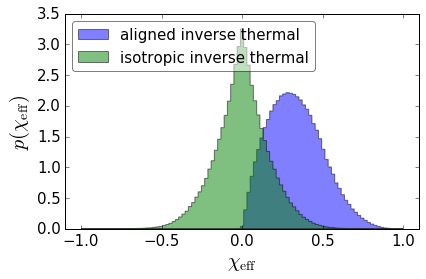

In [44]:
figname="inverse_thermal_only_models"
plt.figure()
plt.clf()
plt.hist(chi_eff_aligned_inverse_thermal_spin, bins=bins_chi_eff, color='blue', histtype='stepfilled', alpha=0.5, label=r"aligned inverse thermal", normed=True) #histtype='step'
plt.hist(chi_eff_isotropic_inverse_thermal_spin, bins=bins_chi_eff, color='green', histtype='stepfilled', alpha=0.5, label=r"isotropic inverse thermal", normed=True) #histtype='step',
plt.xlim([-1.1,1.1])
plt.ylim([0.0, 3.5])
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=15)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

Generate approximation to the prior lalinference uses on $\chi_\mathrm{eff}$. It assumes spins are isotropic, with $\cos{\theta_1}$, $\cos{\theta_w}$ between -1 and 1, and the spin magnitudes $\chi_1$ and $\chi_2$ uniformly between 0 and 1.

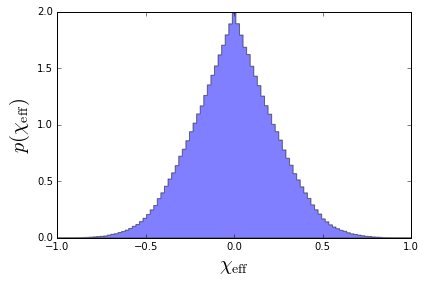

In [45]:
# lalinf_chi_eff_prior = np.random.uniform(-1.0, 1.0, npts)
lalinf_chi_eff_prior = chi_eff_isotropic_uniform_spin
lalinf_chi_eff_prior_binned, bins = np.histogram(lalinf_chi_eff_prior, bins=bins_chi_eff, normed=False)
lalinf_chi_eff_prior_binned = lalinf_chi_eff_prior_binned.astype(float)
lalinf_chi_eff_prior_binned += np.ones_like(lalinf_chi_eff_prior_binned) * (1.0/nbins_chi_eff)
lalinf_chi_eff_prior_binned /= np.sum(lalinf_chi_eff_prior_binned)

figname="lalinf_chi_eff_prior"
plt.figure()
plt.clf()
h = plt.hist(lalinf_chi_eff_prior, bins=bins_chi_eff, histtype='stepfilled', normed=True, alpha=0.5)
plt.xlim()
plt.ylim()
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

Get values for $\chi_\mathrm{eff}$ for the detections from the O1 BBH paper : https://arxiv.org/pdf/1606.04856v3.pdf and make approximations of the posteriors

In [46]:
def convert_90_percent_range_to_sigma(median, upper_90, lower_90):
    """
    Based on Will's function in the 
    
    Parameters
    -----------
    median : float
        median
    upper_90 : float
        90% upper limit
    lower_90 : float
        90% lower limit
        
    Returns
    --------
    sigma : float
        Standard deviation of a gaussian with same 90% range
    
    -- Simon Stevenson
    """
    normal_distribution = scipy.stats.distributions.norm(0.0, 1.0)
    interval_90_gaussian_5 = normal_distribution.ppf(0.05)
    interval_90_gaussian_95 = normal_distribution.ppf(0.95)
    interval_90_gaussian = interval_90_gaussian_95 - interval_90_gaussian_5
    
    this_sigma = (upper_90 - lower_90)/interval_90_gaussian
    
    return this_sigma

In [47]:
#-- these are taken from the paper
GW150914_chi_eff_median  = -0.06
GW151226_chi_eff_median  = 0.21
LVT151012_chi_eff_median = 0.00

GW150914_chi_eff_upper_90 = GW150914_chi_eff_median + 0.14
GW150914_chi_eff_lower_90 = GW150914_chi_eff_median - 0.14 

GW151226_chi_eff_upper_90 = GW151226_chi_eff_median + 0.2
GW151226_chi_eff_lower_90 = GW151226_chi_eff_median - 0.1

LVT151012_chi_eff_upper_90 = LVT151012_chi_eff_median + 0.3
LVT151012_chi_eff_lower_90 = LVT151012_chi_eff_median - 0.2

#-- These are tuned (by eye) to pass the test below
# GW150914_chi_eff_sigma  = 0.1
# GW151226_chi_eff_sigma = 0.15
# LVT151012_chi_eff_sigma = 0.15

#-- These are calculated to have the same 90 percent range as the LIGO measurements
GW150914_chi_eff_sigma = convert_90_percent_range_to_sigma(GW150914_chi_eff_median, GW150914_chi_eff_upper_90, GW150914_chi_eff_lower_90)
GW151226_chi_eff_sigma = convert_90_percent_range_to_sigma(GW151226_chi_eff_median, GW151226_chi_eff_upper_90, GW151226_chi_eff_lower_90)
LVT151012_chi_eff_sigma = convert_90_percent_range_to_sigma(LVT151012_chi_eff_median, LVT151012_chi_eff_upper_90, LVT151012_chi_eff_lower_90)

print("GW150914 sigma = ", GW150914_chi_eff_sigma)
print("GW151226 sigma = ", GW151226_chi_eff_sigma)
print("LVT151012 sigma = ", LVT151012_chi_eff_sigma)

GW150914_chi_eff_post  = scipy.stats.distributions.norm(loc=GW150914_chi_eff_median,  scale=GW150914_chi_eff_sigma).rvs(size=int(1E5)) 
GW151226_chi_eff_post  = scipy.stats.distributions.norm(loc=GW151226_chi_eff_median,  scale=GW151226_chi_eff_sigma).rvs(size=int(1E5)) 
LVT151012_chi_eff_post = scipy.stats.distributions.norm(loc=LVT151012_chi_eff_median, scale=LVT151012_chi_eff_sigma).rvs(size=int(1E5)) 

GW150914 sigma =  0.0851139564676
GW151226 sigma =  0.0911935247868
LVT151012 sigma =  0.151989207978


In [48]:
print("Check these roughly agree with values from O1 BBH paper:")

print("\nGW150914", GW150914_chi_eff_lower_90, GW150914_chi_eff_upper_90)
print("GW151226", GW151226_chi_eff_lower_90, GW151226_chi_eff_upper_90)
print("LVT151012", LVT151012_chi_eff_lower_90, LVT151012_chi_eff_upper_90)

print("\nGW150914", np.percentile(GW150914_chi_eff_post, 5), np.percentile(GW150914_chi_eff_post, 95))
print("GW151226", np.percentile(GW151226_chi_eff_post, 5), np.percentile(GW151226_chi_eff_post, 95))
print("LVT151012", np.percentile(LVT151012_chi_eff_post, 5), np.percentile(LVT151012_chi_eff_post, 95))

Check these roughly agree with values from O1 BBH paper:

GW150914 -0.2 0.08000000000000002
GW151226 0.10999999999999999 0.41000000000000003
LVT151012 -0.2 0.3

GW150914 -0.20088070161 0.0804799614054
GW151226 0.0594547627271 0.360199812432
LVT151012 -0.249946380258 0.249600150416


In [49]:
# #- eyeball
# GW150914 -0.224935234216 0.103245296614
# GW151226 -0.0376251244698 0.455958889317
# LVT151012 -0.247978287589 0.246144927082

# #--will
# GW150914 -0.200156477103 0.0792310604763
# GW151226 0.060402555241 0.359752653163
# LVT151012 -0.250488245828 0.249418068444

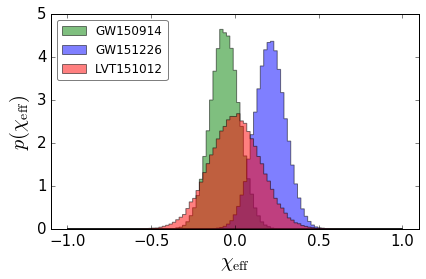

In [50]:
nbins = 40
bins = np.linspace(-1.0, 1.0, nbins)

figname="detections_chi_eff"
plt.figure()
plt.clf()
plt.hist(GW150914_chi_eff_post, bins=bins_chi_eff, color='green', alpha=0.5, histtype='stepfilled', label=r"GW150914", normed=True) #histtype='step'
plt.hist(GW151226_chi_eff_post, bins=bins_chi_eff, color='blue', alpha=0.5, histtype='stepfilled', label=r"GW151226", normed=True) #histtype='step'
plt.hist(LVT151012_chi_eff_post, bins=bins_chi_eff, color='red', alpha=0.5, histtype='stepfilled', label=r"LVT151012", normed=True)
plt.xlim([-1.1,1.1])
# plt.ylim([0.0, 3.0])
plt.xlabel(r"$\chi_\mathrm{eff}$", fontsize=20)
plt.ylabel(r"$p(\chi_\mathrm{eff})$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

Do Christopher's suggested calculation of p(chi_eff > 0) v p(any chi_eff)

In [51]:
GW150914_prob_chi_eff_greater_zero = np.sum(GW150914_chi_eff_post > 0.0)/len(GW150914_chi_eff_post)
GW151226_prob_chi_eff_greater_zero = np.sum(GW151226_chi_eff_post > 0.0)/len(GW151226_chi_eff_post)
LVT151012_prob_chi_eff_greater_zero = np.sum(LVT151012_chi_eff_post > 0.0)/len(LVT151012_chi_eff_post)

print("\np(chi_eff > 0)")
print("GW150914:", GW150914_prob_chi_eff_greater_zero)
print("GW151226:", GW151226_prob_chi_eff_greater_zero)
print("LVT151012:", LVT151012_prob_chi_eff_greater_zero)


p(chi_eff > 0)
GW150914: 0.23959
GW151226: 0.98887
LVT151012: 0.50108


In [52]:
print("Number of events with chi_eff > 0 =", GW150914_prob_chi_eff_greater_zero + GW151226_prob_chi_eff_greater_zero + LVT151012_prob_chi_eff_greater_zero)
print("Expected number of events with chi_eff > 0 if all > 0 = 3")
print("Expected number of events with chi_eff > 0 if symmetric about 0 = 1.5")

Number of events with chi_eff > 0 = 1.72954
Expected number of events with chi_eff > 0 if all > 0 = 3
Expected number of events with chi_eff > 0 if symmetric about 0 = 1.5


In [53]:
print("prob of all 3 with chi_eff > 0 =", GW150914_prob_chi_eff_greater_zero * GW151226_prob_chi_eff_greater_zero * LVT151012_prob_chi_eff_greater_zero)

evidence_chi_eff_positive_chi_eff_any = GW150914_prob_chi_eff_greater_zero * GW151226_prob_chi_eff_greater_zero * LVT151012_prob_chi_eff_greater_zero

C_evidence_chi_eff_positive_chi_eff_any = evidence_chi_eff_positive_chi_eff_any / (1.0 + evidence_chi_eff_positive_chi_eff_any)
sigma_chi_eff_positive_chi_eff_any = scipy.stats.distributions.norm(0.0, 1.0).ppf(C_evidence_chi_eff_positive_chi_eff_any)

print("evidence ratio of aligned model to isotropic model is therefore ", evidence_chi_eff_positive_chi_eff_any)
print("this is", sigma_chi_eff_positive_chi_eff_any ,"sigma")

prob of all 3 with chi_eff > 0 = 0.118717558882
evidence ratio of aligned model to isotropic model is therefore  0.118717558882
this is -1.24743330248 sigma


In [54]:
GW150914_chi_eff_post_binned, bins = np.histogram(GW150914_chi_eff_post, bins=bins_chi_eff, normed=False)
GW151226_chi_eff_post_binned, bins = np.histogram(GW151226_chi_eff_post, bins=bins_chi_eff, normed=False)
LVT151012_chi_eff_post_binned, bins = np.histogram(LVT151012_chi_eff_post, bins=bins_chi_eff, normed=False)

In [55]:
# print(np.sum(GW150914_chi_eff_post_binned))
# print(len(GW150914_chi_eff_post_binned))
# print(GW150914_chi_eff_post_binned)

In [56]:
nDetections = 3 #10 #3
allEventsBinned = np.zeros((nDetections, len(GW150914_chi_eff_post_binned)))

In [57]:
allEventsBinned[0] = GW150914_chi_eff_post_binned
allEventsBinned[1] = GW151226_chi_eff_post_binned
allEventsBinned[2] = LVT151012_chi_eff_post_binned

#-- Add a few more events for fun
# allEventsBinned[3] = GW150914_chi_eff_post_binned
# allEventsBinned[4] = GW150914_chi_eff_post_binned
# allEventsBinned[5] = GW150914_chi_eff_post_binned
# allEventsBinned[6] = GW150914_chi_eff_post_binned
# allEventsBinned[7] = GW150914_chi_eff_post_binned
# allEventsBinned[8] = GW150914_chi_eff_post_binned
# allEventsBinned[9] = GW150914_chi_eff_post_binned

In [58]:
# print(len(allEventsBinned))
# print(allEventsBinned)

Fit a mixture of these models using my hierarchical inference technique

In [59]:
def generateModel(lambdas):
    """
    Generate mixture model
    
    Parameters
    -----------
    
    Returns
    --------
    
    -- Simon Stevenson
    """
    
    this_nLambdas = len(lambdas)
    
    nPointsTotal = len(chi_eff_aligned_fixed_spin)
    
    #nPoints1 = int(nPointsTotal * lambdas[0])
    #nPoints2 = int(nPointsTotal * lambdas[1])
    #nPoints3 = int(nPointsTotal * lambdas[1])
    #nPoints4 = int(nPointsTotal * lambdas[1])
    
    #-- Choose fraction of each model
    this_chi_eff_aligned_fixed_spin     = chi_eff_aligned_fixed_spin[0:int(nPointsTotal * lambdas[0])]
    this_chi_eff_aligned_uniform_spin   = chi_eff_aligned_uniform_spin[0:int(nPointsTotal * lambdas[1])]
    this_chi_eff_isotropic_fixed_spin   = chi_eff_isotropic_fixed_spin[0:int(nPointsTotal * lambdas[2])]
    this_chi_eff_isotropic_uniform_spin = chi_eff_isotropic_uniform_spin[0:int(nPointsTotal * lambdas[3])]
    
    return np.concatenate([this_chi_eff_aligned_fixed_spin, this_chi_eff_aligned_uniform_spin, this_chi_eff_isotropic_fixed_spin, this_chi_eff_isotropic_uniform_spin])

In [60]:
def generateBinnedModel(lambdas, regularise=True):
    """
    Generate a binned model
    
    Parameters
    -----------
    lambdas : float array
        Fractions of each model to use. Add up to 1
    regularise : bool
        Whether to ensure no bin is empty by spreading 1 count over all bins
        
    Returns
    --------
    modelBinnedDensity : float array
        Binned model
    
    -- Simon Stevenson
    """
    model = generateModel(lambdas)
    
    #print(model)
        
    if(regularise):
        
        n, bins = np.histogram(model, bins=bins_chi_eff, normed=False)
        
        n = n.astype(float)
        n += np.ones_like(n) * (1.0/nbins_chi_eff)
        n /= np.sum(n)
    else:
        n, bins = np.histogram(model, bins=bins_chi_eff, normed=True)
    
    return n

In [61]:
def generateBinnedModel2(lambdas, spin_magnitude_distribution_assumption, regularise=True):
    """
    Generate a mixture model where spin magnitudes are drawn uniformly and bin it.
    
    Parameters
    -----------
    
    Returns
    --------
    
    -- Simon Stevenson 
    """
    
    this_nLambdas = len(lambdas)
    
    assert this_nLambdas == 2
    
    nPointsTotal = len(chi_eff_aligned_fixed_spin)
    
    #print(spin_magnitude_distribution_assumption)
    #this_chi_eff_mixture_model = []
    
    #-- Choose fraction of each model
    if(spin_magnitude_distribution_assumption == UNIFORM_SPIN_MAGNITUDE):
        #print("uniform")
        this_chi_eff_aligned_uniform_spin   = chi_eff_aligned_uniform_spin[0:int(nPointsTotal * lambdas[0])]
        this_chi_eff_isotropic_uniform_spin = chi_eff_isotropic_uniform_spin[0:int(nPointsTotal * lambdas[1])]
    
        this_chi_eff_mixture_model = np.concatenate([this_chi_eff_aligned_uniform_spin, this_chi_eff_isotropic_uniform_spin])
    elif(spin_magnitude_distribution_assumption == INVERSE_THERMAL_SPIN_MAGNITUDE):
        #print("inverse thermal")
        #-- Use inverse thermal spin magnitude distribution
        this_chi_eff_aligned_inverse_thermal_spin   = chi_eff_aligned_inverse_thermal_spin[0:int(nPointsTotal * lambdas[0])]
        this_chi_eff_isotropic_inverse_thermal_spin = chi_eff_isotropic_inverse_thermal_spin[0:int(nPointsTotal * lambdas[1])]
    
        this_chi_eff_mixture_model = np.concatenate([this_chi_eff_aligned_inverse_thermal_spin, this_chi_eff_isotropic_inverse_thermal_spin])
    elif(spin_magnitude_distribution_assumption == THERMAL_SPIN_MAGNITUDE):
        #print("thermal")
        #-- Use thermal spin magnitude distribution
        this_chi_eff_aligned_thermal_spin   = chi_eff_aligned_thermal_spin[0:int(nPointsTotal * lambdas[0])]
        this_chi_eff_isotropic_thermal_spin = chi_eff_isotropic_thermal_spin[0:int(nPointsTotal * lambdas[1])]
    
        this_chi_eff_mixture_model = np.concatenate([this_chi_eff_aligned_thermal_spin, this_chi_eff_isotropic_thermal_spin])
    elif(spin_magnitude_distribution_assumption == ZERO_SPIN_MAGNITUDE):
        #print("zero")
        #-- use zero spin magnitude for all BHs
        #this_chi_eff_aligned_zero_spin = chi_eff_zero[0:int(nPointsTotal * lambdas[0])]
        this_chi_eff_mixture_model = chi_eff_zero[0:int(nPointsTotal)]
    elif(spin_magnitude_distribution_assumption == EXTREMELY_LOW_SPIN_MAGNITUDE):
        this_chi_eff_aligned   = chi_eff_aligned_extremely_low[0:int(nPointsTotal * lambdas[0])]
        this_chi_eff_isotropic = chi_eff_isotropic_extremely_low[0:int(nPointsTotal * lambdas[1])]
    
        this_chi_eff_mixture_model = np.concatenate([this_chi_eff_aligned, this_chi_eff_isotropic])
    
    elif(spin_magnitude_distribution_assumption == EXTREMELY_HIGH_SPIN_MAGNITUDE):
        this_chi_eff_aligned   = chi_eff_aligned_extremely_high[0:int(nPointsTotal * lambdas[0])]
        this_chi_eff_isotropic = chi_eff_isotropic_extremely_high[0:int(nPointsTotal * lambdas[1])]
    
        this_chi_eff_mixture_model = np.concatenate([this_chi_eff_aligned, this_chi_eff_isotropic])
        
    elif(spin_magnitude_distribution_assumption == PROXY_ALIGNED):
        this_chi_eff_mixture_model = chi_eff_flat_above_zero
        
    elif(spin_magnitude_distribution_assumption == PROXY_ISOTROPIC):
        this_chi_eff_mixture_model = chi_eff_flat_minus_one_one
        
    else:
        print("error!")
    
    if(regularise):
        
        n, bins = np.histogram(this_chi_eff_mixture_model, bins=bins_chi_eff, normed=False)
        
        n = n.astype(float)
        n += np.ones_like(n) * (1.0/nbins_chi_eff)
        n /= np.sum(n)
    else:
        n, bins = np.histogram(this_chi_eff_mixture_model, bins=bins_chi_eff, normed=True)
    
    return n

In [62]:
def lnprior(theta):
    """
    Parameters
    ----------
    theta : array
    Array containing model parameters (in this case the three lambda values)

    Returns
    --------
    lnprior : float
    log of the prior probabilitiy for these lambda values

    -- Simon Stevenson
    """
#     lambda1, lambda2, lambda3 = theta
#     lambda4 = 1.0 - (lambda1 + lambda2 + lambda3)
#     lambda1, lambda2, lambda3 = theta
#     lambda4 = 1.0 - (lambda1 + lambda2 + lambda3)
#     lambdas = np.array([lambda1, lambda2, lambda3, lambda4])
    
    #-- Pull out the lambdas
    if(np.shape(theta) == ()):
        theta = np.array([theta])
        this_nLambdas = 1
    else:
        this_nLambdas = len(theta) + 1
    
    #-- Will always be one less than the number of models, can reconstruct nth lambda as 1 - sum of others
    lambda_n = np.array([1.0 - np.sum(theta)])
    
    #print(theta.shape)
    #print(lambda_n.shape)

    lambdas = np.concatenate([theta, lambda_n])
    
    lambdas_ok = lambdas >= 0.0
    lambdas_ok = np.logical_and(lambdas_ok, lambdas <= 1.0)
    lambdas_ok = np.logical_and(lambdas_ok, np.sum(lambdas) <= 1.0)
    
#     if(lambda1 >= 0.0 and lambda2 >= 0.0 and lambda3 >= 0.0 and (lambda1 + lambda2 + lambda3 <= 1.0)):
    if(lambdas_ok.all()):
        #-- Flat probability -- in this case should be guaranteed that lambda4 = 1.0 - sum(lambda1-3)
        return 0
        #-- first term is the lambdas, second term is the concentration parameters
        #return scipy.stats.dirichlet.logpdf(np.array([lambda1, lambda2, lambda3, lambda4]), np.ones(nLambdasTest))
    else:
        return -np.inf

In [63]:
def PDFOneEventIlya(data_binned, model_binned, is_logged=False):
    """
    Calculate pdf according to Mandel 2010
    
    Parameters
    ------------
    data_binned : array
        Array containing binned observation counts
    model_binned : array
        Array containing binned model density
    
    Returns
    --------
    pdf : float
        probability p(\mathrm{event} | \vec{\lambda})
    
    -- Simon Stevenson
    """
    nsamples = np.sum(data_binned)
    
    d_i = data_binned
    m_i = model_binned
    p_i = lalinf_chi_eff_prior_binned

    d_i_flat = d_i
    m_i_flat = m_i
    p_i_flat = p_i
    
    #d_i_flat = d_i.reshape(1, d_i.shape[0] * d_i.shape[1])
    #m_i_flat = m_i.reshape(1, m_i.shape[0] * m_i.shape[1])
    #p_i_flat = p_i.reshape(1, p_i.shape[0] * p_i.shape[1])
    
    if(is_logged):
        
        first_term = np.sum(d_i_flat * m_i_flat / p_i_flat)
        
        log_likelihood = np.log(first_term) - np.log(nsamples) 
        
        if(log_likelihood == -np.inf or log_likelihood != log_likelihood):
            print("Error calculating log likelihood for a single event", log_likelihood)
            
        return log_likelihood
    
    else:
        likelihood = (1.0/nsamples) * np.sum(d_i_flat * m_i_flat / p_i_flat)
        
        if(likelihood == 0 or likelihood != likelihood):
            print("Error calculating likelihood for a single event", likelihood)
        
        return likelihood

In [64]:
def lnlike(theta, data, spin_magnitude_distribution_assumption):
    """
    Parameters
    ----------
    theta : array
    Array containing model parameters (in this case the three lambda values)
    data : array
    Array containing binned individual event pdfs
    
    Returns
    --------
    lnposterior : float
    log of the posterior for these lambda values
    
    -- Simon Stevenson
    """
    
    #-- Pull out the lambdas
    if(np.shape(theta) == ()):
        theta = np.array([theta])
        this_nLambdas = 1
    else:
        this_nLambdas = len(theta) + 1
    
    #-- Will always be one less than the number of models, can reconstruct nth lambda as 1 - sum of others
    lambda_n = np.array([1.0 - np.sum(theta)])
    
#     lambda1, lambda2, lambda3 = theta
    
#     lambda4 = 1.0 - (lambda1 + lambda2 + lambda3)
#     lambdas = np.array([lambda1, lambda2, lambda3, lambda4])
    lambdas = np.concatenate([theta, lambda_n])
    
    nIndividualEvents = len(data)
    
    #-- Calculate model at this position in parameter space
    #modelBinnedDensity = generateBinnedModel(lambdas)
    #modelBinnedDensity = generateBinnedModelOnlyUniform(lambdas)
    modelBinnedDensity = generateBinnedModel2(lambdas, spin_magnitude_distribution_assumption)
    
    #is_logged = False
    is_logged = True
    
    logProbabilityLambdaGivenDataIlyaArray = np.zeros(nIndividualEvents)
    probabilityLambdaGivenDataIlyaArray = np.zeros(nIndividualEvents)
    
    for i in range(nIndividualEvents):

        #-- compare each event to the model
        if(is_logged):
            logProbabilityLambdaGivenDataIlyaArray[i] = PDFOneEventIlya(data[i], modelBinnedDensity, is_logged) #-- here data[i] is suppossed to be samplesAllEventsBinned[i]
        else:
            probabilityLambdaGivenDataIlyaArray[i] = PDFOneEventIlya(data[i], modelBinnedDensity) #-- here data[i] is suppossed to be samplesAllEventsBinned[i]        
            logProbabilityLambdaGivenDataIlyaArray[i] = np.log(probabilityLambdaGivenDataIlyaArray[i])

    #-- remember we want to return the log likelihood
    logLikelihoodPoint = np.sum(logProbabilityLambdaGivenDataIlyaArray)
    
    return logLikelihoodPoint

In [65]:
def lnprob(theta, data, spin_magnitude_distribution_assumption):
    """
    Parameters
    ----------
    theta : array
    Array containing model parameters (in this case the three lambda values)
    data : array
    Array containing binned individual event pdfs
    
    Returns
    --------
    lnposterior : float
    log of the posterior for these lambda values
    
    -- Simon Stevenson
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
#         print("Rejected point", theta) #-- if a lot are rejected then maybe you need to be smarter about sampling -- see stan
        return -np.inf
    return lp + lnlike(theta, data, spin_magnitude_distribution_assumption)

In [66]:
def drawLambdasDirichlet(nLambdas=4, nDraws=1000):
    """
    Draw all 4 lambdas at once from a dirichlet distribution. Is the same as drawLambdas.
    However it is 400 times faster :)
    
    Parameters
    -----------
    nLambdas: int
        Number of lambdas to draw
    nDraws: int
        Number of time to draw nLambdas lambdas uniformly
        
    Returns
    --------
    lambdas : array
        Array of shape (nDraws, nLambdas)
        
    -- Simon Stevenson
    """
    lambdas = scipy.stats.dirichlet.rvs(np.ones(nLambdas), size=nDraws)
    
    return lambdas

Check likelihood/posterior function

In [67]:
print(lnprob(np.array([1.0]), allEventsBinned, THERMAL_SPIN_MAGNITUDE)) #-- only aligned
print(lnprob(np.array([0.0]), allEventsBinned, THERMAL_SPIN_MAGNITUDE)) #-- only isotropic
print(lnprob(np.array([0.0]), allEventsBinned, ZERO_SPIN_MAGNITUDE)) #-- only isotropic

-11.2968180636
-0.363458878161
-0.923598428353


Estimate fraction of aligned/isotropic models

In [68]:
nTests = 1000
fractionIsotropicArray = np.linspace(0.0, 1.0, nTests)
fractionAlignedArray = 1.0 - fractionIsotropicArray
# print(fractionIsotropicArray)

In [69]:
lnPrior                   = np.zeros(nTests) 
lnPosteriorThermal        = np.zeros(nTests)
lnPosteriorUniform        = np.zeros(nTests)
lnPosteriorInverseThermal = np.zeros(nTests)

In [70]:
for i in range(nTests):
    lnPrior[i]                   = lnprior(np.array([fractionAlignedArray[i]]))
    lnPosteriorThermal[i]        = lnprob(np.array([fractionAlignedArray[i]]), allEventsBinned, THERMAL_SPIN_MAGNITUDE)
    lnPosteriorUniform[i]        = lnprob(np.array([fractionAlignedArray[i]]), allEventsBinned, UNIFORM_SPIN_MAGNITUDE)
    lnPosteriorInverseThermal[i] = lnprob(np.array([fractionAlignedArray[i]]), allEventsBinned, INVERSE_THERMAL_SPIN_MAGNITUDE)

In [71]:
prior                   = np.exp(lnPrior)
posteriorThermal        = np.exp(lnPosteriorThermal)
posteriorUniform        = np.exp(lnPosteriorUniform)
posteriorInverseThermal = np.exp(lnPosteriorInverseThermal)

dFractionIsotropic = fractionIsotropicArray[1] - fractionIsotropicArray[0]

cumulativePrior              = prior*dFractionIsotropic
cumulativePostThermal        = posteriorThermal*dFractionIsotropic
cumulativePostUniform        = posteriorUniform*dFractionIsotropic
cumulativePostInverseThermal = posteriorInverseThermal*dFractionIsotropic

priorSum                   = np.sum(cumulativePrior)
posteriorSumThermal        = np.sum(cumulativePostThermal)
posteriorSumUniform        = np.sum(cumulativePostUniform)
posteriorSumInverseThermal = np.sum(cumulativePostInverseThermal)

print("Evidence prior = ", priorSum)
print("Evidence thermal = ", posteriorSumThermal)
print("Evidence uniform = ", posteriorSumUniform)
print("Evidence inverse thermal = ", posteriorSumInverseThermal)

#-- Renormalise
priorNormed                   = prior/priorSum
posteriorThermalNormed        = posteriorThermal/posteriorSumThermal
posteriorUniformNormed        = posteriorUniform/posteriorSumUniform
posteriorInverseThermalNormed = posteriorInverseThermal/posteriorSumInverseThermal

#-- recalculate cumulative posterior
cumulativePrior              = priorNormed*dFractionIsotropic
cumulativePostThermal        = posteriorThermalNormed*dFractionIsotropic
cumulativePostUniform        = posteriorUniformNormed*dFractionIsotropic
cumulativePostInverseThermal = posteriorInverseThermalNormed*dFractionIsotropic

cumulativePrior              = np.cumsum(cumulativePrior)
cumulativePostThermal        = np.cumsum(cumulativePostThermal)
cumulativePostUniform        = np.cumsum(cumulativePostUniform)
cumulativePostInverseThermal = np.cumsum(cumulativePostInverseThermal)

print("Check", np.sum(posteriorThermalNormed*dFractionIsotropic), " == 1")
print("Check", np.sum(posteriorUniformNormed*dFractionIsotropic), " == 1")
print("Check", np.sum(posteriorInverseThermalNormed*dFractionIsotropic), " == 1")

Evidence prior =  1.001001001
Evidence thermal =  0.193129061732
Evidence uniform =  0.388796480171
Evidence inverse thermal =  0.84324834263
Check 1.0  == 1
Check 1.0  == 1
Check 1.0  == 1


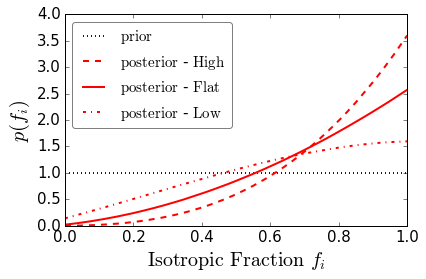

In [72]:
figname="posterior_on_isotropic_fraction"
plt.figure()
plt.clf()
plt.plot(fractionIsotropicArray, prior, lw=2, ls=':', color='blue', label=r"$\mathrm{prior}$")
plt.plot(fractionIsotropicArray, posteriorThermalNormed, lw=2, ls='--', color='red', label=r"$\mathrm{posterior}$ - $\mathrm{High}$")
plt.plot(fractionIsotropicArray, posteriorUniformNormed, lw=2, ls='-', color='red', label=r"$\mathrm{posterior}$ - $\mathrm{Flat}$")
plt.plot(fractionIsotropicArray, posteriorInverseThermalNormed, lw=2, ls='-.', color='red', label=r"$\mathrm{posterior}$ - $\mathrm{Low}$")
plt.xlim()
plt.ylim()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=15)
plt.xlabel(r"$\mathrm{Isotropic}$ $\mathrm{Fraction}$ $f_i$", fontsize=big_enough_font)
plt.ylabel(r"$p(f_i)$", fontsize=big_enough_font)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

Calculate mean fraction from the posteriors

In [73]:
mean_prior = np.mean(prior*fractionIsotropicArray)
mean_posterior_uniform = np.mean(posteriorUniformNormed*fractionIsotropicArray)
mean_posterior_thermal = np.mean(posteriorThermalNormed*fractionIsotropicArray)
mean_posterior_inverse_thermal = np.mean(posteriorInverseThermalNormed*fractionIsotropicArray)

print("prior: mean = ", mean_prior)
print("uniform: mean = ", mean_posterior_uniform)
print("thermal: mean = ", mean_posterior_thermal)
print("inverse thermal: mean = ", mean_posterior_inverse_thermal)

prior: mean =  0.5
uniform: mean =  0.713276309244
thermal: mean =  0.779115853888
inverse thermal: mean =  0.629497255575


Calculate evidence for the models, and calculate evidence ratios between aligned models and mixture models

In [74]:
evidence_all_aligned_uniform = np.exp(lnprob(np.array([1.0]), allEventsBinned, UNIFORM_SPIN_MAGNITUDE))
evidence_all_aligned_thermal = np.exp(lnprob(np.array([1.0]), allEventsBinned, THERMAL_SPIN_MAGNITUDE))
evidence_all_aligned_inverse_thermal = np.exp(lnprob(np.array([1.0]), allEventsBinned, INVERSE_THERMAL_SPIN_MAGNITUDE))

print("\nAll aligned")
print("uniform: ", evidence_all_aligned_uniform)
print("thermal: ", evidence_all_aligned_thermal)
print("inverse thermal:", evidence_all_aligned_inverse_thermal)

#-- NEED TO CHECK THIS!!
evidence_all_isotropic_uniform = np.exp(lnprob(np.array([0.0]), allEventsBinned, UNIFORM_SPIN_MAGNITUDE))
evidence_all_isotropic_thermal = np.exp(lnprob(np.array([0.0]), allEventsBinned, THERMAL_SPIN_MAGNITUDE))
evidence_all_isotropic_inverse_thermal = np.exp(lnprob(np.array([0.0]), allEventsBinned, INVERSE_THERMAL_SPIN_MAGNITUDE))

print("\nAll isotropic")
print("uniform: ", evidence_all_isotropic_uniform)
print("thermal: ", evidence_all_isotropic_thermal)
print("inverse thermal:", evidence_all_isotropic_inverse_thermal)

evidence_all_zero = np.exp(lnprob(np.array([1.0]), allEventsBinned, ZERO_SPIN_MAGNITUDE))
evidence_all_zero_check = np.exp(lnprob(np.array([0.0]), allEventsBinned, ZERO_SPIN_MAGNITUDE)) #-- check doesn't depend on lambda

print("\nAll Zero")
print("zero: ", evidence_all_zero)
print("check: ", evidence_all_zero_check)

evidence_mixture_uniform = posteriorSumUniform
evidence_mixture_thermal = posteriorSumThermal
evidence_mixture_inverse_thermal = posteriorSumInverseThermal

print("\nMixture")
print("uniform: ", evidence_mixture_uniform)
print("thermal: ", evidence_mixture_thermal)
print("inverse thermal:", evidence_mixture_inverse_thermal)


All aligned
uniform:  0.00817055735898
thermal:  1.24123568222e-05
inverse thermal: 0.118775381499

All isotropic
uniform:  1.0
thermal:  0.695267317299
inverse thermal: 1.34725001588

All Zero
zero:  0.397087575925
check:  0.397087575925

Mixture
uniform:  0.388796480171
thermal:  0.193129061732
inverse thermal: 0.84324834263


In [75]:
#-- NEED TO CHECK THIS!!
evidence_all_aligned_extremely_high = np.exp(lnprob(np.array([1.0]), allEventsBinned, EXTREMELY_HIGH_SPIN_MAGNITUDE))
evidence_all_aligned_extremely_low = np.exp(lnprob(np.array([1.0]), allEventsBinned, EXTREMELY_LOW_SPIN_MAGNITUDE))

evidence_all_isotropic_extremely_high = np.exp(lnprob(np.array([0.0]), allEventsBinned, EXTREMELY_HIGH_SPIN_MAGNITUDE))
evidence_all_isotropic_extremely_low = np.exp(lnprob(np.array([0.0]), allEventsBinned, EXTREMELY_LOW_SPIN_MAGNITUDE))

print("\nAll isotropic")
print("Extremely High: ", evidence_all_isotropic_extremely_high)
print("Extremely Low: ", evidence_all_isotropic_extremely_low)

print("\nAll Aligned")
print("Extremely High:", evidence_all_aligned_extremely_high)
print("Extremely Low:", evidence_all_aligned_extremely_low)


All isotropic
Extremely High:  0.454512460195
Extremely Low:  1.15584405534

All Aligned
Extremely High: 2.33572360413e-12
Extremely Low: 0.992221838145


In [76]:
print("Evidence ratio for extreme models")
evidence_ratio_aligned_isotropic_extremely_low = evidence_all_aligned_extremely_low/evidence_all_isotropic_extremely_low
print("Extremely Low:", evidence_ratio_aligned_isotropic_extremely_low)

C_evidence_ratio_aligned_isotropic_extreme_low = evidence_ratio_aligned_isotropic_extremely_low / (1.0 + evidence_ratio_aligned_isotropic_extremely_low)
sigma_evidence_ratio_aligned_isotropic_extreme_low = scipy.stats.distributions.norm(0.0, 1.0).ppf(C_evidence_ratio_aligned_isotropic_extreme_low)

print("corresponds to ", sigma_evidence_ratio_aligned_isotropic_extreme_low, "sigma")

evidence_ratio_aligned_isotropic_extremely_high = evidence_all_aligned_extremely_high/evidence_all_isotropic_extremely_high
print("Extremely High:", evidence_ratio_aligned_isotropic_extremely_high)

Evidence ratio for extreme models
Extremely Low: 0.858439193041
corresponds to  -0.0956127732065 sigma
Extremely High: 5.13896495408e-12


In [77]:
print("Evidence for proxy models")
evidence_aligned_proxy = np.exp(lnprob(np.array([1.0]), allEventsBinned, PROXY_ALIGNED))
evidence_isotropic_proxy = np.exp(lnprob(np.array([1.0]), allEventsBinned, PROXY_ISOTROPIC))

print("Evidence aligned proxy = ", evidence_aligned_proxy)
print("Evidence isotropic proxy = ", evidence_isotropic_proxy)

evidence_ratio_aligned_isotropic_proxy = evidence_aligned_proxy/evidence_isotropic_proxy

print("Evidence ratio aligned/isotropic proxy = ", evidence_ratio_aligned_isotropic_proxy)

C_evidence_ratio_aligned_isotropic_proxy = evidence_ratio_aligned_isotropic_proxy / (1.0 + evidence_ratio_aligned_isotropic_proxy)
sigma_evidence_ratio_aligned_isotropic_proxy = scipy.stats.distributions.norm(0.0, 1.0).ppf(C_evidence_ratio_aligned_isotropic_proxy)

print("corresponds to ", sigma_evidence_ratio_aligned_isotropic_proxy, "sigma")

Evidence for proxy models
Evidence aligned proxy =  0.057622209528
Evidence isotropic proxy =  0.0664722810457
Evidence ratio aligned/isotropic proxy =  0.866860721816
corresponds to  -0.0895022057458 sigma


In [78]:
#-- Calculate evidence ratios

evidence_ratio_all_isotropic_uniform_to_isotropic_uniform = evidence_all_isotropic_uniform/evidence_all_isotropic_uniform
evidence_ratio_all_isotropic_thermal_to_isotropic_uniform = evidence_all_isotropic_thermal/evidence_all_isotropic_uniform
evidence_ratio_all_isotropic_inverse_thermal_to_isotropic_uniform = evidence_all_isotropic_inverse_thermal/evidence_all_isotropic_uniform

evidence_ratio_all_aligned_uniform_to_isotropic_uniform = evidence_all_aligned_uniform/evidence_all_isotropic_uniform
evidence_ratio_all_aligned_thermal_to_isotropic_uniform = evidence_all_aligned_thermal/evidence_all_isotropic_uniform
evidence_ratio_all_aligned_inverse_thermal_to_isotropic_uniform = evidence_all_aligned_inverse_thermal/evidence_all_isotropic_uniform

evidence_ratio_mixture_uniform_to_isotropic_uniform = evidence_mixture_uniform/evidence_all_isotropic_uniform
evidence_ratio_mixture_thermal_to_isotropic_uniform = evidence_mixture_thermal/evidence_all_isotropic_uniform
evidence_ratio_mixture_inverse_thermal_to_isotropic_uniform = evidence_mixture_inverse_thermal/evidence_all_isotropic_uniform

evidence_ratio_all_zero_to_isotropic_uniform = evidence_all_zero / evidence_all_isotropic_uniform

print("\nEvidence ratios")
print("Isotropic")
print("FI", evidence_ratio_all_isotropic_uniform_to_isotropic_uniform, np.log10(evidence_ratio_all_isotropic_uniform_to_isotropic_uniform))
print("II", evidence_ratio_all_isotropic_thermal_to_isotropic_uniform, np.log10(evidence_ratio_all_isotropic_thermal_to_isotropic_uniform))
print("DI", evidence_ratio_all_isotropic_inverse_thermal_to_isotropic_uniform, np.log10(evidence_ratio_all_isotropic_inverse_thermal_to_isotropic_uniform))

print("\nAligned")
print("FA", evidence_ratio_all_aligned_uniform_to_isotropic_uniform, np.log10(evidence_ratio_all_aligned_uniform_to_isotropic_uniform))
print("IA", evidence_ratio_all_aligned_thermal_to_isotropic_uniform, np.log10(evidence_ratio_all_aligned_thermal_to_isotropic_uniform))
print("DA", evidence_ratio_all_aligned_inverse_thermal_to_isotropic_uniform, np.log10(evidence_ratio_all_aligned_inverse_thermal_to_isotropic_uniform))

print("\nMixture")
print("FM", evidence_ratio_mixture_uniform_to_isotropic_uniform, np.log10(evidence_ratio_mixture_uniform_to_isotropic_uniform))
print("IM", evidence_ratio_mixture_thermal_to_isotropic_uniform, np.log10(evidence_ratio_mixture_thermal_to_isotropic_uniform))
print("DM", evidence_ratio_mixture_inverse_thermal_to_isotropic_uniform, np.log10(evidence_ratio_mixture_inverse_thermal_to_isotropic_uniform))

print("\nZero")
print("zero: ", evidence_ratio_all_zero_to_isotropic_uniform)

# evidence_ratio_something = 0

# print("Z_aligned/Z_mix = ", evidence_ratio_something)


Evidence ratios
Isotropic
FI 1.0 0.0
II 0.695267317299 -0.157848185184
DI 1.34725001588 0.129448197387

Aligned
FA 0.00817055735898 -2.08774831682
IA 1.24123568222e-05 -4.9061457481
DA 0.118775381499 -0.925273565979

Mixture
FM 0.388796480171 -0.410277675457
IM 0.193129061732 -0.714152369411
DM 0.84324834263 -0.074044503726

Zero
zero:  0.397087575925


In [109]:
def sigma_from_odds_ratio(odds_ratio):
    """
    Convert odds ratio to equivalent sigma
    
    Parameters
    ------------
    odds_ratio : float
    
    Returns
    --------
    
    
    -- Simon Stevenson
    """
    return scipy.stats.distributions.norm(0.0, 1.0).ppf(1.0 - (odds_ratio/2.0))

In [110]:
evidence_ratio_all_aligned_uniform_to_isotropic_uniform = evidence_all_aligned_uniform/evidence_all_isotropic_uniform
print(evidence_ratio_all_aligned_uniform_to_isotropic_uniform)
print(sigma_from_odds_ratio(evidence_ratio_all_aligned_uniform_to_isotropic_uniform))

0.00817055735898
2.644939295


In [112]:
evidence_ratio_all_aligned_decreasing_to_isotropic_decreasing = evidence_all_aligned_inverse_thermal/evidence_all_isotropic_inverse_thermal
print("odds ratio = ", evidence_ratio_all_aligned_decreasing_to_isotropic_decreasing)
print("sigma = ", sigma_from_odds_ratio(evidence_ratio_all_aligned_decreasing_to_isotropic_decreasing))

odds ratio =  0.0881613509737
sigma =  1.70517736076


Plot cumulative posteriors

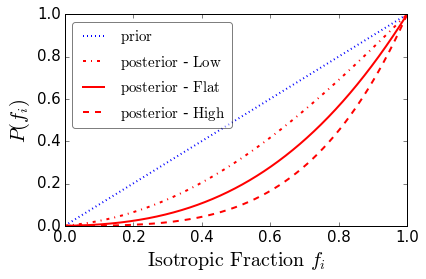

In [81]:
figname="isotropic_fraction_cumulative_posterior"
plt.figure()
plt.clf()
plt.plot(fractionIsotropicArray, cumulativePrior, lw=2, c='b', ls=':', label=r"$\mathrm{prior}$")
plt.plot(fractionIsotropicArray, cumulativePostInverseThermal, lw=2, c='r', ls='-.', label=r"$\mathrm{posterior}$ - $\mathrm{Low}$")
plt.plot(fractionIsotropicArray, cumulativePostUniform, lw=2, c='r', ls='-', label=r"$\mathrm{posterior}$ - $\mathrm{Flat}$")
plt.plot(fractionIsotropicArray, cumulativePostThermal, lw=2, c='r', ls='--', label=r"$\mathrm{posterior}$ - $\mathrm{High}$")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$\mathrm{Isotropic}$ $\mathrm{Fraction}$ $f_i$", fontsize=big_enough_font)
plt.ylabel(r"$P(f_i)$", fontsize=big_enough_font)
plt.legend(loc='upper left', framealpha=0.5, fancybox=True, fontsize=15)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

Calculate lower 90% on mixture fraction

In [82]:
def calculate_percentile(x, fraction_isotropic, cumulative_post):
    """
    Calculate the xth percentile of the posterior
    
    Parameters
    ------------
    x : float
        percentile to calculate (as a fraction 0-1)
    cumulative_post : float array
        Array containing cumulative posterior 
        
    Returns
    --------
    percentile : float
        xth percentile of posterior
    
    -- Simon Stevenson
    """
    return fraction_isotropic[np.argmin(np.abs(cumulative_post - x))]

In [83]:
print("Lower 90% limits are:")
print("prior: ", calculate_percentile(0.1, fractionIsotropicArray, cumulativePrior))
print("post decreasing: ", calculate_percentile(0.1, fractionIsotropicArray, cumulativePostInverseThermal))
print("post flat: ", calculate_percentile(0.1, fractionIsotropicArray, cumulativePostUniform))
print("post increasing: ", calculate_percentile(0.1, fractionIsotropicArray, cumulativePostThermal))

Lower 90% limits are:
prior:  0.0990990990991
post decreasing:  0.262262262262
post flat:  0.389389389389
post increasing:  0.517517517518


Remake Will's Figure

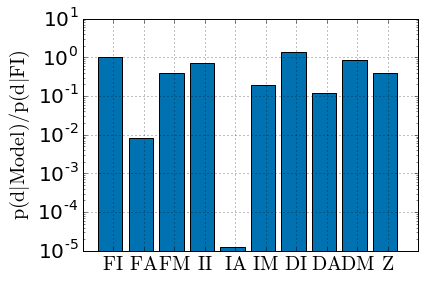

In [84]:
figname="Wills_evidence_ratio_figure_with_mixture_models"
plt.figure()
plt.clf()
toplot=[evidence_ratio_all_isotropic_uniform_to_isotropic_uniform,
        evidence_ratio_all_aligned_uniform_to_isotropic_uniform,
        evidence_ratio_mixture_uniform_to_isotropic_uniform,
        evidence_ratio_all_isotropic_thermal_to_isotropic_uniform, 
        evidence_ratio_all_aligned_thermal_to_isotropic_uniform,
        evidence_ratio_mixture_thermal_to_isotropic_uniform,
        evidence_ratio_all_isotropic_inverse_thermal_to_isotropic_uniform,
        evidence_ratio_all_aligned_inverse_thermal_to_isotropic_uniform,
        evidence_ratio_mixture_inverse_thermal_to_isotropic_uniform,
        evidence_ratio_all_zero_to_isotropic_uniform]
labels = [r'$\mathrm{FI}$', r'$\mathrm{FA}$', r'$\mathrm{FM}$', r'$\mathrm{II}$', r'$\mathrm{IA}$', r'$\mathrm{IM}$', r'$\mathrm{DI}$', r'$\mathrm{DA}$', r'$\mathrm{DM}$', r'$\mathrm{Z}$']
bar_loc = np.arange(len(labels))+1
tick_loc = bar_loc+0.5  
plt.bar(bar_loc, toplot, log=True, color=[0.0/255.0,114.0/255.0,178/255.0])
plt.grid()
plt.xlim([0.5, 11.5])
plt.ylim()
plt.xticks(tick_loc, labels, fontsize=big_enough_font)
plt.yticks(fontsize=big_enough_font)
plt.xlabel(r"", fontsize=big_enough_font)
plt.ylabel(r"$\mathrm{p(d|Model) / p(d|FI)}$", fontsize=big_enough_font)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

In [85]:
print(tick_loc)
print(bar_loc)

[  1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5]
[ 1  2  3  4  5  6  7  8  9 10]


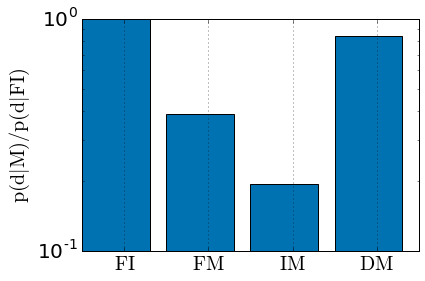

In [86]:
figname="evidence_ratio_figure_mixture_models"
plt.figure()
plt.clf()
toplot=[evidence_ratio_all_isotropic_uniform_to_isotropic_uniform,
        evidence_ratio_mixture_uniform_to_isotropic_uniform,
        evidence_ratio_mixture_thermal_to_isotropic_uniform,
        evidence_ratio_mixture_inverse_thermal_to_isotropic_uniform]
plt.bar([1,2,3,4],toplot, log=True, color=[0.0/255.0,114.0/255.0,178/255.0])
plt.grid()
plt.xlim()
plt.ylim()
plt.xticks([1.5,2.5,3.5,4.5], [r'$\mathrm{FI}$', r'$\mathrm{FM}$', r'$\mathrm{IM}$', r'$\mathrm{DM}$'], fontsize=big_enough_font)
plt.yticks(fontsize=big_enough_font)
plt.xlabel(r"", fontsize=big_enough_font)
plt.ylabel(r"$\mathrm{p(d|M) / p(d|FI)}$", fontsize=big_enough_font)
plt.tight_layout()
plt.savefig(this_plot_folder + figname + ".png", dpi=400)

Put evidence ratio calculation in a for loop, make a plot of typical spin magnitude against sigma. 
Could include 2 axes, one for power law power and one for mean(a)

In [87]:
power_law_powers = np.array([0, 1, 2, 3, 4, 5, 6])
mean_a = np.zeros(len(power_law_powers))
evidences_aligned_extremely_low = np.zeros(len(power_law_powers))
evidences_isotropic_extremely_low = np.zeros(len(power_law_powers))
evidences_ratios_extremely_low = np.zeros(len(power_law_powers))

In [88]:
def p_low_alpha(x, alpha):
    return (1.0-x)**alpha

In [89]:
for i in range(len(power_law_powers)):
    
    #-- Generate spin magnitudes
    
    nmultiplier=10
    chi1_extremely_low = np.random.uniform(0.0, 1.0, nmultiplier*npts)
    prob_chi1_extremely_low = p_low_alpha(chi1_extremely_low, power_law_powers[i])
    chi1_rands = np.random.uniform(0.0, max(prob_chi1_extremely_low), nmultiplier*npts)
    chi1_keep = chi1_rands < prob_chi1_extremely_low
    chi1_extremely_low = chi1_extremely_low[chi1_keep]
    if(len(chi1_extremely_low) > npts):
        chi1_extremely_low = chi1_extremely_low[0:npts]
    else:
        print(len(chi1_extremely_low))

    nmultiplier=10
    chi2_extremely_low = np.random.uniform(0.0, 1.0, nmultiplier*npts)
    prob_chi2_extremely_low = p_low_alpha(chi2_extremely_low, power_law_powers[i])
    chi2_rands = np.random.uniform(0.0, max(prob_chi2_extremely_low), nmultiplier*npts)
    chi2_keep = chi2_rands < prob_chi2_extremely_low
    chi2_extremely_low = chi2_extremely_low[chi2_keep]
    if(len(chi2_extremely_low) > npts):
        chi2_extremely_low = chi2_extremely_low[0:npts]
    else:
        print(len(chi2_extremely_low))
    
    #-- Generate chi eff
    
    chi_eff_aligned_extremely_low = chi_eff(mass_ratio, chi1_extremely_low, chi2_extremely_low, aligned_model_costheta1, aligned_model_costheta2)
    chi_eff_isotropic_extremely_low = chi_eff(mass_ratio, chi1_extremely_low, chi2_extremely_low, isotropic_model_costheta1, isotropic_model_costheta2)

    #-- Calculate evidence for aligned and isotropic models
    
    evidences_aligned_extremely_low[i] = np.exp(lnprob(np.array([1.0]), allEventsBinned, EXTREMELY_LOW_SPIN_MAGNITUDE))
    evidences_isotropic_extremely_low[i] = np.exp(lnprob(np.array([0.0]), allEventsBinned, EXTREMELY_LOW_SPIN_MAGNITUDE))

    #-- Calculate evidence ratio aligned to isotropic model
    evidences_ratios_extremely_low[i] = evidences_aligned_extremely_low[i]/evidences_isotropic_extremely_low[i]
    
    #print(i, np.mean(chi1_extremely_low))
    
    mean_a[i] = np.mean(chi1_extremely_low)
    


# print("\nAll isotropic")
# print("Extremely High: ", evidence_all_isotropic_extremely_high)
# print("Extremely Low: ", evidence_all_isotropic_extremely_low)

# print("\nAll Aligned")
# print("Extremely High:", evidence_all_aligned_extremely_high)
# print("Extremely Low:", evidence_all_aligned_extremely_low)

In [123]:
print(evidences_ratios_extremely_low)

[ 0.00829437  0.08801855  0.27797554  0.55318063  0.86033002  1.15917882
  1.42357634]


In [124]:
print(chi1_extremely_low)

print(np.mean(chi1_extremely_low))

[ 0.17261648  0.28722992  0.03230224 ...,  0.07074466  0.02967268
  0.22649318]
0.125309166542


In [125]:
print(mean_a)

[ 0.4996592   0.33372608  0.24978518  0.19970837  0.16662232  0.14285928
  0.12530917]


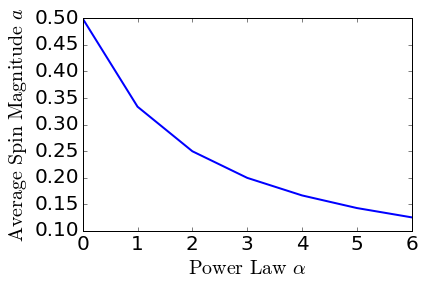

In [126]:
plt.figure()
plt.clf()
plt.plot(power_law_powers, mean_a, lw=2)
plt.xlim()
plt.ylim()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r"$\mathrm{Power}$ $\mathrm{Law}$ $\alpha$", fontsize=20)
plt.ylabel(r"$\mathrm{Average}$ $\mathrm{Spin}$ $\mathrm{Magnitude}$ $a$", fontsize=20)
plt.tight_layout()

In [127]:
sigma_evidences_ratios_extremely_low = sigma_from_odds_ratio(evidences_ratios_extremely_low)

In [128]:
print(sigma_evidences_ratios_extremely_low)

[ 2.63984606  1.70594379  1.08487834  0.59300078  0.17595407 -0.20084321
 -0.55861623]


In [119]:
def tick_function(X):
    return ["%.2f" % z for z in X]

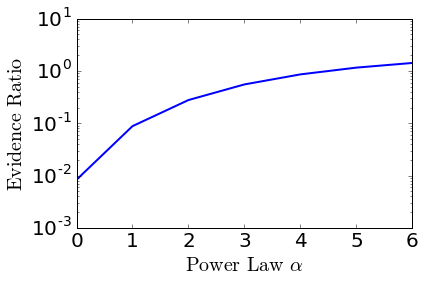

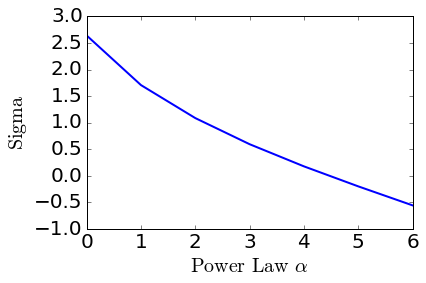

In [121]:
plt.figure()
plt.clf()
plt.plot(power_law_powers, evidences_ratios_extremely_low, lw=2)
plt.xlim()
plt.ylim()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r"$\mathrm{Power}$ $\mathrm{Law}$ $\alpha$", fontsize=20)
plt.ylabel(r"$\mathrm{Evidence}$ $\mathrm{Ratio}$", fontsize=20)
plt.yscale('log')
plt.tight_layout()

plt.figure()
plt.clf()
plt.plot(power_law_powers, sigma_evidences_ratios_extremely_low, lw=2)
plt.xlim()
plt.ylim()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r"$\mathrm{Power}$ $\mathrm{Law}$ $\alpha$", fontsize=20)
plt.ylabel(r"$\mathrm{Sigma}$", fontsize=20)
plt.tight_layout()

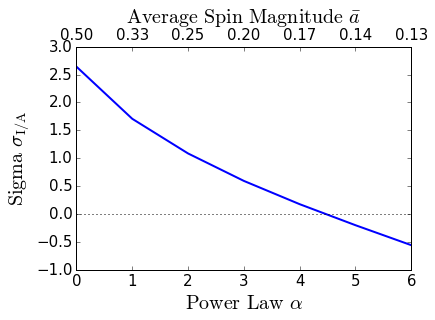

In [129]:
fig = plt.figure()
fig.clf()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(power_law_powers, sigma_evidences_ratios_extremely_low, lw=2, color='b', alpha=1)
# ax1.set_xticklabels( fontsize=15)
# ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=15)
ax1.set_xlabel(r"$\mathrm{Power}$ $\mathrm{Law}$ $\alpha$", fontsize=20)
ax1.set_ylabel(r"$\mathrm{Sigma}$ $\sigma_\mathrm{I/A}$", fontsize=20)

plt.axhline(0, c='k', ls=':')
# plt.xticks(fontsize=15)
ax1.tick_params(labelsize=15)

ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks()
ax2.tick_params(labelsize=15)
ax2.set_xticklabels(tick_function(mean_a)) #, fontsize=15
ax2.set_xlabel(r"$\mathrm{Average}$ $\mathrm{Spin}$ $\mathrm{Magnitude}$ $\bar{a}$", fontsize=20)

plt.savefig(this_plot_folder + "sigma_v_alpha.png", dpi=400, bbox_inches='tight')
